In [1]:
import matplotlib.pyplot as plt
import seaborn as sns 
import matplotlib as mpl 
import matplotlib.pylab as pylab  
import numpy as np 

C:\Users\ASUS\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Data Prepration

In [2]:
import re   
sentences = """We are about to study the idea of a computational process.
Computational processes are abstract beings that inhabit computers.
As they evolve, processes manipulate other abstract things called data.
The evolution of a process is directed by a pattern of rules
called a program. People create programs to direct processes. In effect,
we conjure the spirits of the computer with our spells."""


In [3]:
#Clean Data
#remove special characters
sentences=re.sub('[^A-Za-z0-9]+', ' ',sentences)

In [4]:
# remove 1 letter words
sentences=re.sub(r'(?:^| )\w(?:$| )', ' ',sentences).strip()

In [5]:
#lower all characters
sentences=sentences.lower()

In [6]:
#vocabulary
words=sentences.split() 
vocab=set(words)  
vocab_size=len(vocab) 
embed_dim=10  #determines the size of word embeddings. Each word in the vocabulary will be represented as a 10-dimensional vector in the embedding space.
context_size=2 #considering a window of two words to the left and two words to the right of a target word.

In [7]:
#Creating the dictonary
word_to_ix={word:i for i,word in enumerate(vocab)}
ix_to_word={i:word for i, word in enumerate(vocab)}

In [8]:
#data bags
data=[]
for i in range(2,len(words)-2):
    context=[words[i-2],words[i-1],words[i+1],words[i+2]]
    target=words[i]
    data.append((context,target))
print(data[:5])

[(['we', 'are', 'to', 'study'], 'about'), (['are', 'about', 'study', 'the'], 'to'), (['about', 'to', 'the', 'idea'], 'study'), (['to', 'study', 'idea', 'of'], 'the'), (['study', 'the', 'of', 'computational'], 'idea')]


In [9]:
embeddings=np.random.random_sample((vocab_size, embed_dim))   # creates a NumPy array embedding with random values. 

In [10]:
#linear model
def linear(m,theta):
    w=theta
    return m.dot(w)

In [11]:
def log_softmax(x):           #To convert a vector of raw scores (logits) into a probability distribution. The log of the softmax function is
    e_x=np.exp(x-np.max(x))   #frequently used in loss functions, such as the cross-entropy loss, for training classification models.
    return np.log(e_x/e_x.sum())

def NLLLoss(logs,targets):  #Negative Log Likelihood (NLL). This loss is commonly used for training classification models.
    out=logs[range(len(targets)),targets]  #This results in a 1D array containing the log probabilities for each data point's correct class.
    return -out.sum()/len(out) 

def log_softmax_crossentropy_with_logits(logits,target):
    out=np.zeros_like(logits)         #This line creates an array out with the same shape as logits but filled with zeros.
    out[np.arange(len(logits)),target]=1  #This line sets the one-hot encoded values for the target labels. For each data point, it sets the value in the row corresponding to the target label to 1, effectively creating a one-hot encoded matrix.
    softmax=np.exp(logits)/np.exp(logits).sum(axis=-1,keepdims=True) #It calculates the exponentials of the logits, then normalizes these values by dividing by the sum along the class dimension (axis -1) to obtain a probability distribution. 
    return(-out+softmax)/logits.shape[0] #the function returns the cross-entropy loss, which is the element-wise subtraction of the one-hot encoded target matrix (out) from the softmax probabilities (softmax).
    #The result is then divided by the number of data points (samples or examples) to compute the average loss over the entire dataset.

In [12]:
#Forward Function
def forward(context_idxs, theta):
    m=embeddings[context_idxs].reshape(1,-1) #calculated by selecting the embeddings for the words in the context using the provided indices (context_idxs). These embeddings are reshaped into a 1D vector 
    n=linear(m,theta) #This step combines the context word embeddings to make predictions about the target word.
    o=log_softmax(n)  #The log softmax function converts the raw scores in n into a probability distribution over possible word classes.
    
    return m,n,o

# context_idxs: a list of indices that correspond to words in the context.
# theta: a set of parameters or weights that the model uses for its calculations.
# embeddings: These are numerical representations of words, like vectors, which the model uses to understand the meaning of words.


In [13]:
#Backward Function responsible for computing gradients with respect to model parameters
def backward(preds,theta,target_idxs):
    m,n,o=preds
    dlog=log_softmax_crossentropy_with_logits(n,target_idxs)
    dw=m.T.dot(dlog) #T is used for transpose matrix or array
    return dw #dw, which represents the gradients of the loss with respect to the model's parameters. These gradients are used in the optimization process

# preds is a tuple containing three items: m(input representation), n(linear transformation result), and o(output probabilities).
# target_idxs: a list of indices corresponding to the target labels.

In [14]:
#Optimize Function implement a simple parameter update step for optimization using gradient descent. 
def optimize(theta,grad,lr=0.03):
    theta-=grad*lr 
    return theta

#grad: gradients of the loss with respect to the model's parameters.
#lr: It determines the rate at which the model's parameters are adjusted.

In [15]:
##Generate Training Data
theta=np.random.uniform(-1,1,(2*context_size*embed_dim, vocab_size)) 
#-1: inclusive, 1:exclusive 
#This function generate random value between -1 and 1.

epoch_losses={} #dictionary that will store the losses for each epoch.
#The outer loop iterates over a total of 80 epochs. During each epoch, the model will go through the entire training dataset.
for epoch in range(80):
    losses=[]  #This list is used to collect the losses for each batch of data within an epoch.
    
    #The inner loop appears to iterate over batches of data represented by the variables context and target.
    for context,target in data:
        context_idxs=np.array([word_to_ix[w] for w in context]) #created by converting the words in the context to their corresponding indices using the word_to_ix dictionary.
        preds=forward(context_idxs,theta) #which involves processing the input data (context_idxs) with the current model parameters (theta).
        
        target_idxs=np.array([word_to_ix[target]])   #created by converting the target word to its index.
        loss=NLLLoss(preds[-1],target_idxs)     #based on the model's predictions (preds[-1]) and the target indices (target_idxs).
        
        losses.append(loss) #loss added to losses list
        
        grad=backward(preds,theta,target_idxs) #The gradients (grad) are computed using a backward pass (backward) to understand how the parameters need to be adjusted to reduce the loss.
        theta=optimize(theta,grad,lr=0.03)
        
    epoch_losses[epoch]=losses   #the losses for that epoch are added to the epoch_losses dictionary.
    
    #plot loss/epoch
    ix=np.arange(0,80)

Text(0, 0.5, 'Losses')

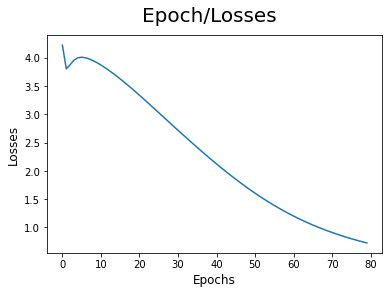

In [16]:
fig=plt.figure()
fig.suptitle('Epoch/Losses',fontsize=20)
plt.plot(ix,[epoch_losses[i][0] for i in ix]) #It plots the losses at the first position [0] within the epoch_losses dictionary for each epoch i in the ix range. This is how the losses for each epoch are displayed over time.
plt.xlabel('Epochs',fontsize=12)
plt.ylabel('Losses',fontsize=12)

In [17]:
def predict(words):
    context_idxs=np.array([word_to_ix[w] for w in words])
    preds=forward(context_idxs,theta)
    word=ix_to_word[np.argmax(preds[-1])]  #used to find the index of the word with the highest prediction score in the final prediction vector preds[-1]
    return word

In [18]:
def accuracy():
    wrong=0
    for context,target in data:
        if(predict(context)!=target):
            wrong+=1
    return (1-(wrong/len(data)))
accuracy()
predict(['processes', 'manipulate', 'things', 'study'])

'abstract'